In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import cv2

In [8]:
df_cyclone_data_image_name = []
df_cyclone_data_level = []

data_folders = glob.glob("Cyclone_Data/*")
level = 0

for directory in data_folders:
    data_files = glob.glob(directory+"//*")
    level += 1
    for file in data_files:
        df_cyclone_data_image_name.append(file)
        df_cyclone_data_level.append(level)

df_cyclone_data = pd.DataFrame()

df_cyclone_data["imageName"] = df_cyclone_data_image_name
df_cyclone_data["Labels"] = df_cyclone_data_level

print(df_cyclone_data.head())


df_cyclone_data = df_cyclone_data.sample(frac = 1.0)
df_cyclone_data.reset_index(inplace = True, drop = True)

print(df_cyclone_data.head())
    

                                           imageName  Labels
0  Cyclone_Data\T1\3DIMG_13DEC2018_0730_L1C_ASIA_...       1
1  Cyclone_Data\T1\3DIMG_13DEC2018_0730_L1C_ASIA_...       1
2  Cyclone_Data\T1\3DIMG_13DEC2018_0730_L1C_ASIA_...       1
3  Cyclone_Data\T1\3DIMG_13DEC2018_0730_L1C_ASIA_...       1
4  Cyclone_Data\T1\3DIMG_13DEC2018_0730_L1C_ASIA_...       1
                                           imageName  Labels
0  Cyclone_Data\T5\3DIMG_31OCT2015_1630_L1C_ASIA_...       5
1  Cyclone_Data\T2\3DIMG_17DEC2018_1130_L1C_ASIA_...       2
2  Cyclone_Data\T3\3DIMG_03NOV2015_0530_L1C_ASIA_...       3
3  Cyclone_Data\T4\3DIMG_26OCT2019_1400_L1C_ASIA_...       4
4  Cyclone_Data\T4\3DIMG_03NOV2019_0800_L1C_ASIA_...       4


In [11]:
from sklearn.model_selection import train_test_split

df_cyclone_train_data, df_cyclone_test = train_test_split(df_cyclone_data, stratify=df_cyclone_data["Labels"], test_size = 0.30)
df_cyclone_train, df_cyclone_cv = train_test_split(df_cyclone_train_data, stratify=df_cyclone_train_data["Labels"], test_size = 0.20)
print(df_cyclone_train.shape, df_cyclone_cv.shape, df_cyclone_test.shape)

(3897, 2) (975, 2) (2088, 2)


In [12]:
df_cyclone_train.reset_index(inplace = True, drop = True)
df_cyclone_train.to_pickle("Cyclone_Data/df_cyclone_train.pkl")

df_cyclone_cv.reset_index(inplace = True, drop = True)
df_cyclone_cv.to_pickle("Cyclone_Data/df_cyclone_cv.pkl")

df_cyclone_test.reset_index(inplace = True, drop = True)
df_cyclone_test.to_pickle("Cyclone_Data/df_cyclone_test.pkl")

In [14]:
train_cyclone = pd.read_pickle("Cyclone_Data/df_cyclone_train.pkl")
train_cyclone.head()

,imageName,Labels
0,Cyclone_Data\T1\3DIMG_24MAY2021_0200_L1C_ASIA_...,1
1,Cyclone_Data\T4\3DIMG_17DEC2018_0630_L1C_ASIA_...,4
2,Cyclone_Data\T6\3DIMG_18MAY2020_0700_L1C_ASIA_...,6
3,Cyclone_Data\T2\3DIMG_14MAY2020_0300_L1C_ASIA_...,2
4,Cyclone_Data\T1\3DIMG_14DEC2018_1500_L1C_ASIA_...,1


In [15]:
train_cyclone_Labels = pd.get_dummies(train_cyclone["Labels"]).to_numpy()
train_cyclone_Labels.shape

(3897, 7)

In [17]:
train_cyclone_Labels

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [31]:
TrainCombined_batch_pointer = 0

In [32]:
def loadCombinedTrainBatch(batch_size):
    global TrainCombined_batch_pointer
    batch_images = []
    batch_labels = []
    for i in range(batch_size):
        read_image = cv2.imread(train_cyclone.iloc[TrainCombined_batch_pointer + i]["imageName"])
        #print(os.path.join(path1, path2))
        read_image_final = read_image/255.0  #here, we are normalizing the images
        batch_images.append(read_image_final)
        #print(read_image_final.shape)
        batch_labels.append(train_cyclone_Labels[TrainCombined_batch_pointer + i]) #appending corresponding labels
        
    TrainCombined_batch_pointer += batch_size
        
    return np.array(batch_images), np.array(batch_labels)

In [33]:
from tensorflow.keras.applications import ResNet152V2

In [34]:
model = ResNet152V2( weights="imagenet", include_top=False)

In [35]:
SAVEDIR = "Cyclone_Data/Bottleneck_CombinedTrain/"
SAVEDIR_LABELS = "Cyclone_Data/Cyclone_Train_Labels/"
batch_size = 10
print(int(len(train_cyclone)/batch_size))
for i in range(int(len(train_cyclone)/batch_size)-5):
    x, y = loadCombinedTrainBatch(batch_size)
    print("Batch {} loaded".format(i+1))

    print(x.shape)
    
    np.save(os.path.join(SAVEDIR_LABELS, "bottleneck_labels_{}".format(i+1)), y)
    
    print("Creating bottleneck features for batch {}". format(i+1))
    bottleneck_features = model.predict(x)
    np.save(os.path.join(SAVEDIR, "bottleneck_{}".format(i+1)), bottleneck_features)
    print("Bottleneck features for batch {} created and saved\n".format(i+1))
    print("Shape of bottleneck features {}\n".format(bottleneck_features.shape))

389
Batch 1 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 1
1/1 [==============================] - 2s 2s/step
Bottleneck features for batch 1 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 2 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 2
1/1 [==============================] - 0s 391ms/step
Bottleneck features for batch 2 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 3 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 3
1/1 [==============================] - 0s 393ms/step
Bottleneck features for batch 3 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 4 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 4
1/1 [==============================] - 0s 392ms/step
Bottleneck features for batch 4 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 5 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 5
1/1 [====================

1/1 [==============================] - 0s 386ms/step
Bottleneck features for batch 37 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 38 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 38
1/1 [==============================] - 0s 382ms/step
Bottleneck features for batch 38 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 39 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 39
1/1 [==============================] - 0s 384ms/step
Bottleneck features for batch 39 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 40 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 40
1/1 [==============================] - 0s 387ms/step
Bottleneck features for batch 40 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 41 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 41
1/1 [==============================] - 0s 388ms/step
Bottleneck features for batch 41 cr

1/1 [==============================] - 0s 381ms/step
Bottleneck features for batch 73 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 74 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 74
1/1 [==============================] - 0s 381ms/step
Bottleneck features for batch 74 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 75 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 75
1/1 [==============================] - 0s 380ms/step
Bottleneck features for batch 75 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 76 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 76
1/1 [==============================] - 0s 381ms/step
Bottleneck features for batch 76 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 77 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 77
1/1 [==============================] - 0s 378ms/step
Bottleneck features for batch 77 cr

1/1 [==============================] - 0s 382ms/step
Bottleneck features for batch 109 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 110 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 110
1/1 [==============================] - 0s 380ms/step
Bottleneck features for batch 110 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 111 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 111
1/1 [==============================] - 0s 383ms/step
Bottleneck features for batch 111 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 112 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 112
1/1 [==============================] - 0s 381ms/step
Bottleneck features for batch 112 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 113 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 113
1/1 [==============================] - 0s 383ms/step
Bottleneck features for

1/1 [==============================] - 0s 380ms/step
Bottleneck features for batch 145 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 146 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 146
1/1 [==============================] - 0s 379ms/step
Bottleneck features for batch 146 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 147 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 147
1/1 [==============================] - 0s 380ms/step
Bottleneck features for batch 147 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 148 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 148
1/1 [==============================] - 0s 377ms/step
Bottleneck features for batch 148 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 149 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 149
1/1 [==============================] - 0s 381ms/step
Bottleneck features for

1/1 [==============================] - 0s 385ms/step
Bottleneck features for batch 181 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 182 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 182
1/1 [==============================] - 0s 383ms/step
Bottleneck features for batch 182 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 183 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 183
1/1 [==============================] - 0s 390ms/step
Bottleneck features for batch 183 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 184 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 184
1/1 [==============================] - 0s 383ms/step
Bottleneck features for batch 184 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 185 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 185
1/1 [==============================] - 0s 389ms/step
Bottleneck features for

1/1 [==============================] - 0s 380ms/step
Bottleneck features for batch 217 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 218 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 218
1/1 [==============================] - 0s 377ms/step
Bottleneck features for batch 218 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 219 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 219
1/1 [==============================] - 0s 378ms/step
Bottleneck features for batch 219 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 220 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 220
1/1 [==============================] - 0s 382ms/step
Bottleneck features for batch 220 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 221 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 221
1/1 [==============================] - 0s 381ms/step
Bottleneck features for

1/1 [==============================] - 0s 386ms/step
Bottleneck features for batch 253 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 254 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 254
1/1 [==============================] - 0s 377ms/step
Bottleneck features for batch 254 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 255 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 255
1/1 [==============================] - 0s 496ms/step
Bottleneck features for batch 255 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 256 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 256
1/1 [==============================] - 0s 497ms/step
Bottleneck features for batch 256 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 257 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 257
1/1 [==============================] - 0s 498ms/step
Bottleneck features for

1/1 [==============================] - 0s 486ms/step
Bottleneck features for batch 289 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 290 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 290
1/1 [==============================] - 0s 488ms/step
Bottleneck features for batch 290 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 291 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 291
1/1 [==============================] - 0s 489ms/step
Bottleneck features for batch 291 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 292 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 292
1/1 [==============================] - 0s 489ms/step
Bottleneck features for batch 292 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 293 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 293
1/1 [==============================] - 0s 488ms/step
Bottleneck features for

1/1 [==============================] - 0s 494ms/step
Bottleneck features for batch 325 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 326 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 326
1/1 [==============================] - 0s 493ms/step
Bottleneck features for batch 326 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 327 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 327
1/1 [==============================] - 0s 493ms/step
Bottleneck features for batch 327 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 328 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 328
1/1 [==============================] - 1s 505ms/step
Bottleneck features for batch 328 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 329 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 329
1/1 [==============================] - 0s 491ms/step
Bottleneck features for

1/1 [==============================] - 0s 495ms/step
Bottleneck features for batch 361 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 362 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 362
1/1 [==============================] - 0s 494ms/step
Bottleneck features for batch 362 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 363 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 363
1/1 [==============================] - 0s 491ms/step
Bottleneck features for batch 363 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 364 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 364
1/1 [==============================] - 0s 493ms/step
Bottleneck features for batch 364 created and saved

Shape of bottleneck features (10, 4, 4, 2048)

Batch 365 loaded
(10, 128, 128, 3)
Creating bottleneck features for batch 365
1/1 [==============================] - 0s 493ms/step
Bottleneck features for

In [41]:
cv_cyclone = pd.read_pickle("Cyclone_Data/df_cyclone_cv.pkl")
cv_cyclone.head()

,imageName,Labels
0,Cyclone_Data\T6\3DIMG_18MAY2020_0330_L1C_ASIA_...,6
1,Cyclone_Data\T5\3DIMG_18MAY2020_0400_L1C_ASIA_...,5
2,Cyclone_Data\T1\3DIMG_13DEC2018_2330_L1C_ASIA_...,1
3,Cyclone_Data\T3\3DIMG_02NOV2019_0400_L1C_ASIA_...,3
4,Cyclone_Data\T3\3DIMG_03NOV2019_0930_L1C_ASIA_...,3


In [42]:
cv_cyclone_Labels = pd.get_dummies(cv_cyclone["Labels"]).to_numpy()
cv_cyclone_Labels.shape

(975, 7)

In [47]:
CVCyclone_batch_pointer = 0

In [48]:
def loadCycloneCVBatch(batch_size):
    global CVCyclone_batch_pointer
    batch_images = []
    batch_labels = []
    for i in range(batch_size):
        read_image = cv2.imread(cv_cyclone.iloc[CVCyclone_batch_pointer + i]["imageName"])
        read_image_final = read_image/255.0  #here, we are normalizing the images
        batch_images.append(read_image_final)
        
        batch_labels.append(cv_cyclone_Labels[CVCyclone_batch_pointer + i]) #appending corresponding labels
        
    CVCyclone_batch_pointer += batch_size
        
    return np.array(batch_images), np.array(batch_labels)

In [49]:
model = ResNet152V2( weights="imagenet", include_top=False)

In [50]:
SAVEDIR = "Cyclone_Data/Bottleneck_Cylone_CV/"
SAVEDIR_LABELS = "Cyclone_Data/Cyclone_CV_Labels/"
batch_size = 10
print(int(len(cv_cyclone)/batch_size))
for i in range(int(len(cv_cyclone)/batch_size)):
    x, y = loadCycloneCVBatch(batch_size)
    print("Batch {} loaded".format(i+1))
    
    np.save(os.path.join(SAVEDIR_LABELS, "bottleneck_labels_{}".format(i+1)), y)
    
    print("Creating bottleneck features for batch {}". format(i+1))
    bottleneck_features = model.predict(x)
    np.save(os.path.join(SAVEDIR, "bottleneck_{}".format(i+1)), bottleneck_features)
    print("Bottleneck features for batch {} created and saved\n".format(i+1))

97
Batch 1 loaded
Creating bottleneck features for batch 1
1/1 [==============================] - 3s 3s/step
Bottleneck features for batch 1 created and saved

Batch 2 loaded
Creating bottleneck features for batch 2
1/1 [==============================] - 1s 572ms/step
Bottleneck features for batch 2 created and saved

Batch 3 loaded
Creating bottleneck features for batch 3
1/1 [==============================] - 1s 565ms/step
Bottleneck features for batch 3 created and saved

Batch 4 loaded
Creating bottleneck features for batch 4
1/1 [==============================] - 1s 561ms/step
Bottleneck features for batch 4 created and saved

Batch 5 loaded
Creating bottleneck features for batch 5
1/1 [==============================] - 1s 559ms/step
Bottleneck features for batch 5 created and saved

Batch 6 loaded
Creating bottleneck features for batch 6
1/1 [==============================] - 1s 563ms/step
Bottleneck features for batch 6 created and saved

Batch 7 loaded
Creating bottleneck featu

In [51]:
test_cyclone = pd.read_pickle("Cyclone_Data/df_cyclone_test.pkl")
test_cyclone.head()

,imageName,Labels
0,Cyclone_Data\T3\3DIMG_07NOV2019_2130_L1C_ASIA_...,3
1,Cyclone_Data\T4\3DIMG_17MAY2020_0800_L1C_ASIA_...,4
2,Cyclone_Data\T3\3DIMG_14DEC2018_1730_L1C_ASIA_...,3
3,Cyclone_Data\T6\3DIMG_28OCT2019_0730_L1C_ASIA_...,6
4,Cyclone_Data\T5\3DIMG_18MAY2020_0800_L1C_ASIA_...,5


In [52]:
test_cyclone_Labels = pd.get_dummies(test_cyclone["Labels"]).to_numpy()
test_cyclone_Labels.shape

(2088, 7)

In [58]:
TestCyclone_batch_pointer = 0

In [59]:
def loadCycloneTestBatch(batch_size):
    global TestCyclone_batch_pointer
    batch_images = []
    batch_labels = []
    for i in range(batch_size):
        read_image = cv2.imread(test_cyclone.iloc[TestCyclone_batch_pointer + i]["imageName"])
        read_image_final = read_image/255.0  #here, we are normalizing the images
        batch_images.append(read_image_final)
        #print(read_image_final.shape)
        batch_labels.append(test_cyclone_Labels[TestCyclone_batch_pointer + i]) #appending corresponding labels
        
    TestCyclone_batch_pointer += batch_size
        
    return np.array(batch_images), np.array(batch_labels)

In [60]:
SAVEDIR = "Cyclone_Data/Bottleneck_Cyclone_Test/"
SAVEDIR_LABELS = "Cyclone_Data/Cyclone_Test_Labels/"
print(test_cyclone.shape)
batch_size = 10
print(int(len(test_cyclone)/batch_size))
for i in range(int(len(test_cyclone)/batch_size)):
    #print(i)
    x, y = loadCycloneTestBatch(batch_size)
    #print(x, y)
    print("Batch {} loaded".format(i+1))
    
    np.save(os.path.join(SAVEDIR_LABELS, "bottleneck_labels_{}".format(i+1)), y)
    
    print("Creating bottleneck features for batch {}". format(i+1))
    bottleneck_features = model.predict(x)
    np.save(os.path.join(SAVEDIR, "bottleneck_{}".format(i+1)), bottleneck_features)
    print("Bottleneck features for batch {} created and saved\n".format(i+1))

(2088, 2)
208
Batch 1 loaded
Creating bottleneck features for batch 1
1/1 [==============================] - 1s 535ms/step
Bottleneck features for batch 1 created and saved

Batch 2 loaded
Creating bottleneck features for batch 2
1/1 [==============================] - 1s 529ms/step
Bottleneck features for batch 2 created and saved

Batch 3 loaded
Creating bottleneck features for batch 3
1/1 [==============================] - 1s 519ms/step
Bottleneck features for batch 3 created and saved

Batch 4 loaded
Creating bottleneck features for batch 4
1/1 [==============================] - 1s 527ms/step
Bottleneck features for batch 4 created and saved

Batch 5 loaded
Creating bottleneck features for batch 5
1/1 [==============================] - 1s 531ms/step
Bottleneck features for batch 5 created and saved

Batch 6 loaded
Creating bottleneck features for batch 6
1/1 [==============================] - 1s 526ms/step
Bottleneck features for batch 6 created and saved

Batch 7 loaded
Creating bo

1/1 [==============================] - 1s 545ms/step
Bottleneck features for batch 51 created and saved

Batch 52 loaded
Creating bottleneck features for batch 52
1/1 [==============================] - 1s 548ms/step
Bottleneck features for batch 52 created and saved

Batch 53 loaded
Creating bottleneck features for batch 53
1/1 [==============================] - 1s 540ms/step
Bottleneck features for batch 53 created and saved

Batch 54 loaded
Creating bottleneck features for batch 54
1/1 [==============================] - 1s 536ms/step
Bottleneck features for batch 54 created and saved

Batch 55 loaded
Creating bottleneck features for batch 55
1/1 [==============================] - 1s 529ms/step
Bottleneck features for batch 55 created and saved

Batch 56 loaded
Creating bottleneck features for batch 56
1/1 [==============================] - 1s 526ms/step
Bottleneck features for batch 56 created and saved

Batch 57 loaded
Creating bottleneck features for batch 57
1/1 [=================

1/1 [==============================] - 1s 522ms/step
Bottleneck features for batch 151 created and saved

Batch 152 loaded
Creating bottleneck features for batch 152
1/1 [==============================] - 1s 512ms/step
Bottleneck features for batch 152 created and saved

Batch 153 loaded
Creating bottleneck features for batch 153
1/1 [==============================] - 1s 522ms/step
Bottleneck features for batch 153 created and saved

Batch 154 loaded
Creating bottleneck features for batch 154
1/1 [==============================] - 1s 534ms/step
Bottleneck features for batch 154 created and saved

Batch 155 loaded
Creating bottleneck features for batch 155
1/1 [==============================] - 1s 532ms/step
Bottleneck features for batch 155 created and saved

Batch 156 loaded
Creating bottleneck features for batch 156
1/1 [==============================] - 1s 541ms/step
Bottleneck features for batch 156 created and saved

Batch 157 loaded
Creating bottleneck features for batch 157
1/1 

1/1 [==============================] - 1s 525ms/step
Bottleneck features for batch 201 created and saved

Batch 202 loaded
Creating bottleneck features for batch 202
1/1 [==============================] - 1s 529ms/step
Bottleneck features for batch 202 created and saved

Batch 203 loaded
Creating bottleneck features for batch 203
1/1 [==============================] - 1s 538ms/step
Bottleneck features for batch 203 created and saved

Batch 204 loaded
Creating bottleneck features for batch 204
1/1 [==============================] - 1s 545ms/step
Bottleneck features for batch 204 created and saved

Batch 205 loaded
Creating bottleneck features for batch 205
1/1 [==============================] - 1s 527ms/step
Bottleneck features for batch 205 created and saved

Batch 206 loaded
Creating bottleneck features for batch 206
1/1 [==============================] - 1s 535ms/step
Bottleneck features for batch 206 created and saved

Batch 207 loaded
Creating bottleneck features for batch 207
1/1 

In [63]:
from keras.layers import Dropout, Dense
#from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model
from keras.applications import VGG16
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, AveragePooling1D, BatchNormalization, Input, Flatten, Dropout, Activation
from keras.utils import to_categorical, np_utils
from keras.optimizers import Adam

In [68]:
no_of_classes = 7

#training the model
SAVEDIR_COMB_TRAIN = "Cyclone_Data/Bottleneck_CombinedTrain/"
SAVEDIR_COMB_TRAIN_LABELS = "Cyclone_Data/Cyclone_Train_Labels/"

SAVEDIR_CV_HUMANS = "Cyclone_Data/Bottleneck_Cylone_CV/"
SAVEDIR_CV_HUMANS_LABELS = "Cyclone_Data/Cyclone_CV_Labels/"



SAVER = "Cyclone_Data/Model_Save/"

input_shape = 4*4*2048   #this is the shape of bottleneck feature of each image which comes after passing the image through ResNet-152V2
print("#",input_shape)


model = Sequential()

model.add(Dense(512, activation='relu', input_dim = input_shape))

#model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
    
#model.add(Dense(1024, activation='relu'))

model.add(Dense(256, activation='relu'))

#model.add(Dense(256, activation='relu'))
    
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
    
#model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(Dense(16, activation='relu'))
model.add(Dense(no_of_classes, activation='softmax'))


# model.load_weights(os.path.join(SAVER, "model.h5"))
model.summary()
opt = Adam()
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ["accuracy"])

epochs = 100
batch_size = 10
step = 0
combTrain_bottleneck_files = int(len(train_cyclone)/batch_size)-5
CVHuman_bottleneck_files = int(len(cv_cyclone)/batch_size)
#CVAnime_bottleneck_files = int(len(CV_Animated) / batch_size)
epoch_number, CombTrain_loss, CombTrain_acc, CVHuman_loss, CVHuman_acc = [], [], [], [], []

for epoch in range(epochs):
    avg_epoch_CombTr_loss, avg_epoch_CombTr_acc, avg_epoch_CVHum_loss, avg_epoch_CVHum_acc = 0, 0, 0, 0
    epoch_number.append(epoch + 1)
    
    for i in range(combTrain_bottleneck_files):
        
        step += 1
        
        #loading batch of train bottleneck features for training MLP.
        X_CombTrain_load = np.load(os.path.join(SAVEDIR_COMB_TRAIN, "bottleneck_{}.npy".format(i+1)))
        X_CombTrain = X_CombTrain_load.reshape(X_CombTrain_load.shape[0], X_CombTrain_load.shape[1]*X_CombTrain_load.shape[2]*X_CombTrain_load.shape[3])
        Y_CombTrain = np.load(os.path.join(SAVEDIR_COMB_TRAIN_LABELS, "bottleneck_labels_{}.npy".format(i+1)))
        
        #loading batch of Human CV bottleneck features for cross-validation.
        X_CVHuman_load = np.load(os.path.join(SAVEDIR_CV_HUMANS, "bottleneck_{}.npy".format((i % CVHuman_bottleneck_files) + 1)))
        X_CVHuman = X_CVHuman_load.reshape(X_CVHuman_load.shape[0], X_CVHuman_load.shape[1]*X_CVHuman_load.shape[2]*X_CVHuman_load.shape[3])
        Y_CVHuman = np.load(os.path.join(SAVEDIR_CV_HUMANS_LABELS, "bottleneck_labels_{}.npy".format((i % CVHuman_bottleneck_files) + 1)))
        
        #loading batch of animated CV bottleneck features for cross-validation.
        #X_CVAnime_load = np.load(os.path.join(SAVEDIR_CV_ANIME, "bottleneck_{}.npy".format((i % CVAnime_bottleneck_files) + 1)))
        #X_CVAnime = X_CVAnime_load.reshape(X_CVAnime_load.shape[0], X_CVAnime_load.shape[1]*X_CVAnime_load.shape[2]*X_CVAnime_load.shape[3])
        #Y_CVAnime = np.load(os.path.join(SAVEDIR_CV_ANIME_LABELS, "bottleneck_labels_{}.npy".format((i % CVAnime_bottleneck_files) + 1)))
        
        CombTrain_Loss, CombTrain_Accuracy = model.train_on_batch(X_CombTrain, Y_CombTrain) #train the model on batch
        CVHuman_Loss, CVHuman_Accuracy = model.test_on_batch(X_CVHuman, Y_CVHuman) #cross validate the model on CV Human batch
        #CVAnime_Loss, CVAnime_Accuracy = model.test_on_batch(X_CVAnime, Y_CVAnime) #cross validate the model on CV Animated batch
        
        #print("Epoch: {}, Step: {}, CombTr_Loss: {}, CombTr_Acc: {}, CVHum_Loss: {}, CVHum_Acc: {}, CVAni_Loss: {}, CVAni_Acc: {}".format(epoch+1, step, np.round(float(CombTrain_Loss), 2), np.round(float(CombTrain_Accuracy), 2), np.round(float(CVHuman_Loss), 2), np.round(float(CVHuman_Accuracy), 2), np.round(float(CVAnime_Loss), 2), np.round(float(CVAnime_Accuracy), 2)))
        
        avg_epoch_CombTr_loss += CombTrain_Loss / combTrain_bottleneck_files
        avg_epoch_CombTr_acc += CombTrain_Accuracy / combTrain_bottleneck_files
        avg_epoch_CVHum_loss += CVHuman_Loss / combTrain_bottleneck_files
        avg_epoch_CVHum_acc += CVHuman_Accuracy / combTrain_bottleneck_files
        #avg_epoch_CVAnime_loss += CVAnime_Loss / combTrain_bottleneck_files
        #avg_epoch_CVAnime_acc += CVAnime_Accuracy / combTrain_bottleneck_files
        
    #print("Avg_CombTrain_Loss: {}, Avg_CombTrain_Acc: {}, Avg_CVHum_Loss: {}, Avg_CVHum_Acc: {}, Avg_CVAnime_Loss: {}, Avg_CVAnime_Acc: {}".format(np.round(float(avg_epoch_CombTr_loss), 2), np.round(float(avg_epoch_CombTr_acc), 2), np.round(float(avg_epoch_CVHum_loss), 2), np.round(float(avg_epoch_CVHum_acc), 2), np.round(float(avg_epoch_CVAnime_loss), 2), np.round(float(avg_epoch_CVAnime_acc), 2)))

    CombTrain_loss.append(avg_epoch_CombTr_loss)
    CombTrain_acc.append(avg_epoch_CombTr_acc)
    CVHuman_loss.append(avg_epoch_CVHum_loss)
    CVHuman_acc.append(avg_epoch_CVHum_acc)
    #CVAnime_loss.append(avg_epoch_CVAnime_loss)
    #CVAnime_acc.append(avg_epoch_CVAnime_acc)
    
    model.save(os.path.join(SAVER, "model.h5"))  #saving the model on each epoc
    model.save_weights(os.path.join(SAVER, "model_weights.h5")) #saving the weights of model on each epoch
    print("Model and weights saved at epoch {}".format(epoch + 1))
          
log_frame = pd.DataFrame(columns = ["Epoch", "Comb_Train_Loss", "Comb_Train_Accuracy", "CV_Loss", "CV_Accuracy"])
log_frame["Epoch"] = epoch_number
log_frame["Comb_Train_Loss"] = CombTrain_loss
log_frame["Comb_Train_Accuracy"] = CombTrain_acc
log_frame["CV_Loss"] = CVHuman_loss
log_frame["CV_Accuracy"] = CVHuman_acc
#log_frame["CVAnime_Loss"] = CVAnime_loss
#log_frame["CVAnime_Accuracy"] = CVAnime_acc
log_frame.to_csv("Cyclone_Data/Logs/Log.csv", index = False)

# 32768
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                              

In [94]:
log = pd.read_csv("Cyclone_Data/Logs/Log.csv")
log

,,Epoch,Comb_Train_Loss,Comb_Train_Accuracy,CV_Loss,CV_Accuracy
1,1.228756,0.495052,1.920791,0.454688,NaN,NaN
2,0.928754,0.627604,1.245142,0.533854,NaN,NaN
3,0.662438,0.744531,0.980216,0.638021,NaN,NaN
4,0.497196,0.804427,1.019908,0.647656,NaN,NaN
5,0.388419,0.855990,0.899728,0.691146,NaN,NaN
...,...,...,...,...,...,...
96,0.017069,0.992708,1.862122,0.753906,NaN,NaN
97,0.017459,0.994010,1.820841,0.759635,NaN,NaN
98,0.015831,0.995573,1.726075,0.761979,NaN,NaN
99,0.021301,0.992187,1.791955,0.759635,NaN,NaN


In [107]:
CYCLONE_T_LEVEL = {1:"T1.5", 2:"T2", 3:"T3", 4:"T4", 5:"T5", 6:"T6", 7:"T7"}
model_ResNet = ResNet152V2( weights="imagenet", include_top=False)
model_top = load_model("Cyclone_Data/Model_Save/model.h5")

In [108]:
def make_prediction(path):
    
    #read the processed image then make prediction and display the result
    read_image = cv2.imread(path)
    read_image = read_image.reshape(1, read_image.shape[0], read_image.shape[1], read_image.shape[2])
    read_image_final = read_image/255.0  #normalizing the image
    ResNet_Pred = model_ResNet.predict(read_image_final)  #creating bottleneck features of image using ResNet.
    print(ResNet_Pred.shape)
    ResNet_Pred = ResNet_Pred.reshape(1, ResNet_Pred.shape[1]*ResNet_Pred.shape[2]*ResNet_Pred.shape[3])
    top_pred = model_top.predict(ResNet_Pred)  #making prediction from our own model.
    cyclone_label = top_pred[0].argmax() + 1
    print("Predicted Cyclone Probabilities")
    print("T1.5: {}\nT2: {}\nT3: {}\nT4: {}\nT5: {}\nT6: {}\nT7: {}\n\n".format(top_pred[0][0], top_pred[0][1], top_pred[0][2], top_pred[0][3], top_pred[0][4], top_pred[0][5], top_pred[0][6]))
    print("Dominant Probability = "+str(CYCLONE_T_LEVEL[cyclone_label])+": "+str(max(top_pred[0])))

In [109]:
read_image = cv2.imread("Cyclone_Data/T5/3DIMG_01NOV2015_0430_L1C_ASIA_MER_IMG_TIR1._rotate_120.jpeg")
read_image = read_image.reshape(1, read_image.shape[0], read_image.shape[1], read_image.shape[2])
read_image_final = read_image/255.0 
ResNet_Pred = model_ResNet.predict(read_image_final) 

1/1 [==============================] - 3s 3s/step


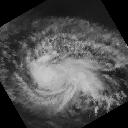

In [114]:
Image.open("Cyclone_Data/T2/3DIMG_02NOV2019_1300_L1C_ASIA_MER_IMG_TIR1._rotate_120.jpeg")

In [115]:
make_prediction("Cyclone_Data/T2/3DIMG_02NOV2019_1300_L1C_ASIA_MER_IMG_TIR1._rotate_120.jpeg")

1/1 [==============================] - 0s 178ms/step
(1, 4, 4, 2048)
1/1 [==============================] - 0s 18ms/step
Predicted Cyclone Probabilities
T1.5: 4.282011545342357e-08
T2: 0.9999992847442627
T3: 6.462393571382563e-07
T4: 8.654553636244788e-12
T5: 3.256830569120517e-12
T6: 5.3305636814326984e-12
T7: 4.644276885235e-16


Dominant Probability = T2: 0.9999993
